In [1]:
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import os
from xarrayutils.cm26_codebucket import cm26_loadall_run, time_add_refyear, shift_lon
from xarrayutils.utils import composite
import numpy as np

In [2]:
from dask.distributed import Client
client = Client(scheduler_file='/home/Julius.Busecke/scheduler.json')
client.restart()

Client Scheduler: tcp://140.208.147.171:8786 Dashboard: http://140.208.147.171:7272/status,Cluster Workers: 8 Cores: 152 Memory: 1024.00 GB


# What do I need for this project

- EUC strength
- Surface Windstress

In [3]:
# ############################################################
# # Extract Equator data from archive monthly snapshot files #
# ############################################################

# path = '/archive/wga/CM2.6/CM2.6_A_Control-1860_V03/pp/ocean/ts/monthly/5yr'
# odir = '/work/Julius.Busecke/CM2.6_staged/CM2.6_A_Control-1860_V03/EUC_extracted'
# kw = dict(decode_times=False)

# ds_u = xr.open_mfdataset(os.path.join(path,'ocean.*.u.nc'), **kw)
# ds_u

# ds_tau_x = xr.open_mfdataset(os.path.join(path,'ocean.*.tau_x.nc'), **kw)
# ds_tau_x

# region_3d = dict(yu_ocean=slice(-5,5), xu_ocean=slice(-270,-60), st_ocean=slice(0,300))
# region_2d = dict(yu_ocean=slice(-5,5), xu_ocean=slice(-270,-60))

# ds_final = xr.merge([ds_tau_x.sel(**region_2d), ds_u.sel(**region_3d)])
# ds_final

# ds_final.load().to_netcdf(os.path.join(odir,'EUC_cut.nc'))

In [4]:
odir = '/work/Julius.Busecke/CM2.6_staged/CM2.6_A_Control-1860_V03/EUC_extracted'
kw = dict(decode_times=False, chunks={'time':1})

ds = xr.open_dataset(os.path.join(odir,'EUC_cut.nc'), **kw)
ds = time_add_refyear(ds)
ds

<xarray.Dataset>
Dimensions:         (nv: 2, st_edges_ocean: 51, st_ocean: 28, sw_edges_ocean: 51, time: 2400, xt_ocean: 3600, xu_ocean: 2101, yt_ocean: 2700, yu_ocean: 101)
Coordinates:
  * xt_ocean        (xt_ocean) float64 -279.9 -279.8 -279.7 -279.6 -279.5 ...
  * yt_ocean        (yt_ocean) float64 -81.11 -81.07 -81.02 -80.98 -80.94 ...
  * nv              (nv) float64 1.0 2.0
  * xu_ocean        (xu_ocean) float64 -270.0 -269.9 -269.8 -269.7 -269.6 ...
  * yu_ocean        (yu_ocean) float64 -4.994 -4.894 -4.794 -4.695 -4.595 ...
  * st_edges_ocean  (st_edges_ocean) float64 0.0 10.07 20.16 30.29 40.47 ...
  * sw_edges_ocean  (sw_edges_ocean) float64 5.034 15.1 25.22 35.36 45.58 ...
    geolon_t        (yt_ocean, xt_ocean) float64 dask.array<shape=(2700, 3600), chunksize=(2700, 3600)>
    geolat_t        (yt_ocean, xt_ocean) float64 dask.array<shape=(2700, 3600), chunksize=(2700, 3600)>
    geolon_c        (yu_ocean, xu_ocean) float64 dask.array<shape=(101, 2101), chunksize=(101, 21

In [5]:
# ds = cm26_loadall_run('control')
# ds_forced = cm26_loadall_run('forced')

In [6]:
ds = shift_lon(ds, 'xu_ocean')
ds = shift_lon(ds, 'xt_ocean')

In [7]:
# Extract the Pacific Equatorial Band #
drop_vars = [d for d in ds.data_vars if d not in ['u', 'tau_x']]
ds_EQ = ds.sel(xt_ocean=slice(172,263), xu_ocean=slice(172,263),
               yt_ocean=slice(-2,2), yu_ocean=slice(-2,2)).drop(drop_vars).persist()

In [9]:
# bins = np.arange(170,270,5)
# bin_labels = (bins[1:] + bins[:-1]) / 2
# ds_EQ = ds_EQ.groupby_bins('xu_ocean', bins, labels=bin_labels).mean('xu_ocean').persist()

In [10]:
ds_EQ.nbytes/1e9

20.798252288

/home/Julius.Busecke/code/src/xarray/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()
/home/Julius.Busecke/code/miniconda/envs/standard/lib/python3.6/site-packages/dask/optimize.py:20: UserWarning: DeprecationWarning: `dask.optimize.inline has moved to `dask.optimization.inline`, please update imports accordingly
  warnings.warn(_msg.format(method))


Text(0.5,1,'EUC section')

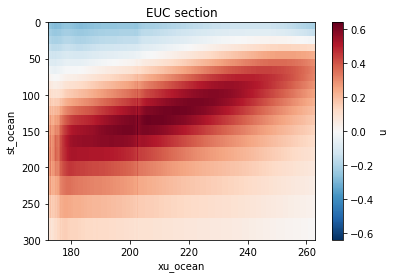

In [11]:
### mean EUC structure
ds_EQ.u.mean(['yu_ocean', 'time']).plot()
plt.gca().set_ylim(0,300)
plt.gca().invert_yaxis()
plt.title('EUC section')

/home/Julius.Busecke/code/miniconda/envs/standard/lib/python3.6/site-packages/dask/optimize.py:20: UserWarning: DeprecationWarning: `dask.optimize.inline has moved to `dask.optimization.inline`, please update imports accordingly
  warnings.warn(_msg.format(method))


Text(0.5,1,'EUC strength')

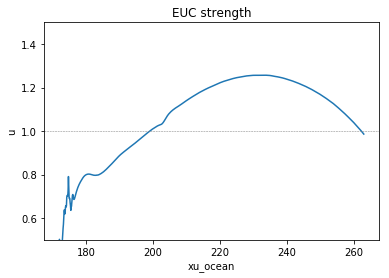

In [15]:
###### EUC strength (meridional and depth max of u)
euc_strength = ds_EQ.u.max(['yu_ocean', 'st_ocean'])
euc_strength.mean('time').plot()
# ds_EQ_forced.u.max(['yu_ocean', 'st_ocean']).mean('time').plot()
plt.axhline(1.0, color='0.5', linestyle='--', linewidth=0.5)
plt.gca().set_ylim(0.5,1.5)
plt.title('EUC strength')

/home/Julius.Busecke/code/miniconda/envs/standard/lib/python3.6/site-packages/dask/optimize.py:20: UserWarning: DeprecationWarning: `dask.optimize.inline has moved to `dask.optimization.inline`, please update imports accordingly
  warnings.warn(_msg.format(method))


Text(0.5,1,'Mean windstress')

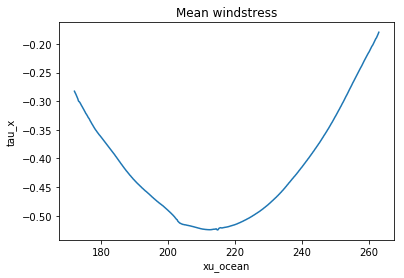

In [16]:
# Mean windstress over the sector
tau_x = (ds_EQ.tau_x * 10).mean('yu_ocean') # conversion to dyne/cm^2
# The y average is not correct (area weighting needed?)
tau_x.mean(['time']).plot() 
plt.title('Mean windstress')

/home/Julius.Busecke/code/miniconda/envs/standard/lib/python3.6/site-packages/dask/optimize.py:20: UserWarning: DeprecationWarning: `dask.optimize.inline has moved to `dask.optimization.inline`, please update imports accordingly
  warnings.warn(_msg.format(method))


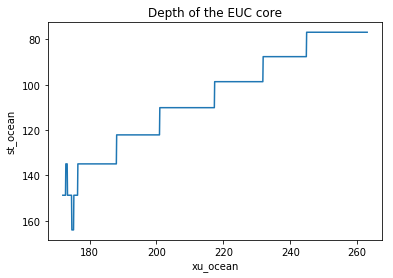

In [14]:
# Depth of the EUC core #

ds_EQ.st_ocean.isel(st_ocean=ds_EQ.u.max(dim=['yu_ocean']).argmax('st_ocean').mean('time').astype(int)).plot()
plt.gca().invert_yaxis()
plt.title('Depth of the EUC core');

In [57]:
def standardize_timeseries(data, preload=True):
    clim_mean = data.groupby('time.month').mean('time')
    clim_std = data.groupby('time.month').std('time')
    if preload:
        clim_mean = clim_mean.load()
        clim_std = clim_std.load()
    data_anom = data.groupby('time.month') - clim_mean
    data_stnd = data_anom.groupby('time.month') / clim_std
    return data_stnd

/home/Julius.Busecke/code/miniconda/envs/standard/lib/python3.6/site-packages/dask/optimize.py:20: UserWarning: DeprecationWarning: `dask.optimize.inline has moved to `dask.optimization.inline`, please update imports accordingly
  warnings.warn(_msg.format(method))


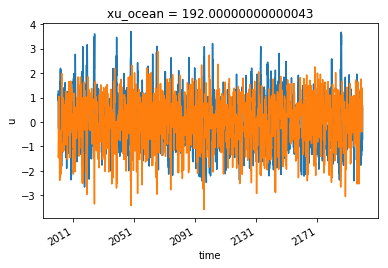

In [59]:
# standardize values
tau_x_stnd = standardize_timeseries(tau_x).load()
tau_x_stnd.isel(xu_ocean=200).plot()

euc_strength_stnd = standardize_timeseries(euc_strength).load()
euc_strength_stnd.isel(xu_ocean=200).plot()

In [17]:
# Correlation between tau and euc_strength

from xarrayutils.utils import xr_linregress

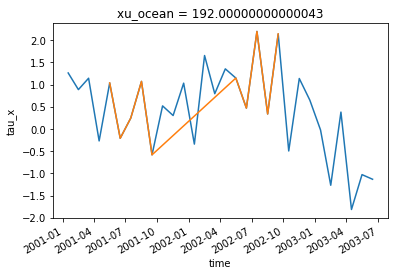

In [69]:
# Test if we are picking the right months?

tau_x_stnd.isel(xu_ocean=200).isel(time=slice(0,30)).plot()
tau_x_stnd.isel(time=index, xu_ocean=200).isel(time=slice(0,10)).plot()

In [73]:
import pandas as pd
index = pd.DatetimeIndex(tau_x.time.data).month

index = [a for a in range(len(index)) if index[a] in list(range(5,10))] #Pick only May-Sept
index

a = tau_x_stnd.isel(time=index)
b = euc_strength_stnd.isel(time=index)
cc = xr_linregress(b, a)
cc

<xarray.Dataset>
Dimensions:    (xu_ocean: 911)
Coordinates:
  * xu_ocean   (xu_ocean) float64 172.0 172.1 172.2 172.3 172.4 172.5 172.6 ...
    parameter  <U9 'std_err'
Data variables:
    slope      (xu_ocean) float64 -0.3672 -0.3579 -0.3501 -0.3412 -0.3333 ...
    intercept  (xu_ocean) float64 -4.338e-18 -1.018e-16 -1.318e-17 1.029e-16 ...
    r_value    (xu_ocean) float64 -0.3672 -0.3579 -0.3501 -0.3412 -0.3333 ...
    p_value    (xu_ocean) float64 2.756e-33 1.382e-31 3.254e-30 1.1e-28 ...
    std_err    (xu_ocean) float64 0.02944 0.02956 0.02965 0.02975 0.02984 ...

Text(0.5,1,'Correlation between standardize tau_x and euc for May-Sept')

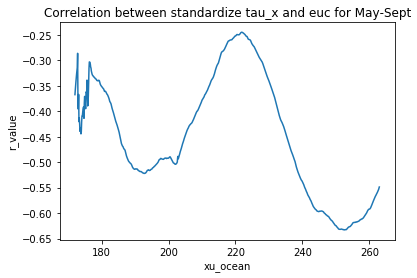

In [74]:
cc.r_value.plot()
plt.title('Correlation between standardize tau_x and euc for May-Sept')

Ummmm so this is weird? The correlation is negative for all longitudes?

Below I will scatter the raw data (no standardization) for some example locations...

/home/Julius.Busecke/code/miniconda/envs/standard/lib/python3.6/site-packages/dask/optimize.py:20: UserWarning: DeprecationWarning: `dask.optimize.inline has moved to `dask.optimization.inline`, please update imports accordingly
  warnings.warn(_msg.format(method))


Text(0.5,1,'example scatter at lon=200')

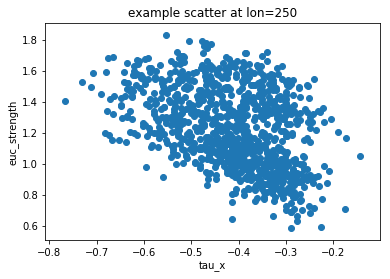

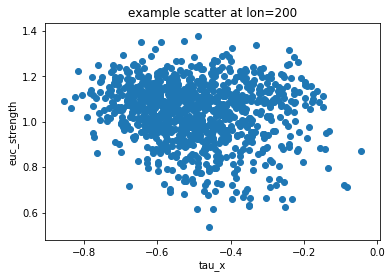

In [79]:
# Example scatterplot (without standardization)
a_test = tau_x.sel(xu_ocean=250, method='nearest').isel(time=index)
b_test = euc_strength.sel(xu_ocean=250, method='nearest').isel(time=index)

plt.figure()
plt.scatter(a_test, b_test)
plt.xlabel('tau_x')
plt.ylabel('euc_strength')
plt.title('example scatter at lon=250')

a_test = tau_x.sel(xu_ocean=200, method='nearest').isel(time=index)
b_test = euc_strength.sel(xu_ocean=200, method='nearest').isel(time=index)

plt.figure()
plt.scatter(a_test, b_test)
plt.xlabel('tau_x')
plt.ylabel('euc_strength')
plt.title('example scatter at lon=200')